Mounted at /content/drive
Cloning into 'GP_try'...
remote: Enumerating objects: 35817, done.
remote: Counting objects: 100% (4800/4800), done.
remote: Compressing objects: 100% (4561/4561), done.
remote: Total 35817 (delta 237), reused 4790 (delta 227), pack-reused 31017
Receiving objects: 100% (35817/35817), 41.95 MiB | 28.28 MiB/s, done.
Resolving deltas: 100% (237/237), done.
Updating files: 100% (30994/30994), done.
/content/GP_try/test
^C
905
1810
3590
75


In [ ]:
%cd /content/GP_try/test

/content/GP_try/test


In [ ]:
import sys; sys.path.append("../")
from feature_extractor import FeatureExtractor
import torch
import numpy as np
import time
from cascade import CascadeClassifier
import cv2

In [ ]:
torch.cuda.is_available()

True

In [ ]:
parent = '../hFeatures3_2/'
data_path = 'new_data3'

# Features Extraction

In [ ]:
mean = 111.02404842061983
std = 56.926623499738575

In [ ]:
def transform1(img):
  return img
  # img = (img - img.mean()) / (img.std() + 1e-8)
  # return cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [ ]:

feature_extractor = FeatureExtractor(shape=(19,19), 
                                     percentile=20,
                                     all_features_file=parent + "all_features.npz",
                                     selected_features_file=parent + "selected_features.npz",
                                     labels_file=parent + "labels.npy",
                                     indecies_file=parent + "indecies.npy",)

In [ ]:

X, y = feature_extractor.extractFeatures(pos_path='../'+data_path+'/train/face', 
                                  neg_path='../'+data_path+'/train/non-face',
                                  transform=transform1,
                                  save_to_file=False)
print('done')


all_features shape: (63960, 10826)
done


In [ ]:
# del feature_extractor.f2
# del feature_extractor.f3
# del feature_extractor.f4

In [ ]:
indecies, X = feature_extractor.selectPercentile(X, y )
# y = np.load(parent + 'labels.npy')
print(X.shape, y.shape)
print('done')


Now selecting percentile features
(12792, 10826) (10826,)
done


In [ ]:
# temp = np.load('../hFeatures3/all_features.npz')['arr_0']
temp = X
temp 

array([[  89., -146.,  118., ...,  -17.,  -51.,  -32.],
       [ 253.,  -35.,  280., ...,  -22., -178.,  -33.],
       [ -46.,  127.,  -83., ...,    9.,    6.,  -12.],
       ...,
       [-111.,  -27.,  -27., ...,   -1.,    1.,    8.],
       [  78., -149.,  -81., ...,   -1.,    7.,   20.],
       [  96., -109.,  -28., ...,    3.,    1.,    5.]], dtype=float32)

In [ ]:
print(temp.min())
print(temp.max())
print(temp[3])
print(temp[4])

-30493.0
28166.0
[ 434.  123.  439. ...   -4. -218.   -7.]
[-115.   84. -116. ...    7.   -2.  -12.]


# Training

In [ ]:
[20]*10

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

In [ ]:
%rm StrongClassifier/lastSC.last
s_t = time.time()
cascadeClassifier= CascadeClassifier(X, y, batchsize=5000, verbose=True, layers=[20]*10)
tr_acc = cascadeClassifier.train()

cascadeClassifier.save(parent + 'cascadeClassifier.pkl')

print('accuracy: ', tr_acc)
print('time taken: ', time.time() - s_t, 's')
print('done')

rm: cannot remove 'StrongClassifier/lastSC.last': No such file or directory
$$$$$$$ Training layer 1 / 10 $$$$$$$
Starting to choose classifier
Finished training weak classifier 1 / 20
Starting to choose classifier
Finished training weak classifier 2 / 20
Starting to choose classifier
Finished training weak classifier 3 / 20
Starting to choose classifier
Finished training weak classifier 4 / 20
Starting to choose classifier
Finished training weak classifier 5 / 20
Starting to choose classifier
Finished training weak classifier 6 / 20
Starting to choose classifier
Finished training weak classifier 7 / 20
Starting to choose classifier
Finished training weak classifier 8 / 20
Starting to choose classifier
Finished training weak classifier 9 / 20
Starting to choose classifier
Finished training weak classifier 10 / 20
Starting to choose classifier
Finished training weak classifier 11 / 20
Starting to choose classifier
Finished training weak classifier 12 / 20
Starting to choose classifier
F

# Testing

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../cascade.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../hFeatures3_2/

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# accuracy imports
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [ ]:
s_t = time.time()
t_f_idx_map, t_features, t_labels = feature_extractor.extractFeaturesByIndecies(pos_path='../'+data_path+'/test/face', 
                                            neg_path='../'+data_path+'/test/non-face',
                                            cascadeClassifier=cascadeClassifier,
                                            transform=transform1)
print(t_features.shape, t_labels.shape)
predictions = cascadeClassifier.predict(t_features, t_f_idx_map)
print('test accuracy: ', np.sum(predictions == t_labels) / t_labels.shape[0])
print('time taken: ', time.time() - s_t, 's')

Now reading dataset...
Now extracting features from dataset...
(57, 2715) (2715,)
test accuracy:  0.9499079189686924
time taken:  1.3454008102416992 s


In [ ]:
# report
print('accuracy: ', accuracy_score(t_labels, predictions))
print('f1 score macro: ', f1_score(t_labels, predictions, average='macro'))
print('f1 score binary: ', f1_score(t_labels, predictions))
print('f1 score micro: ', f1_score(t_labels, predictions, average='micro'))
print('precision: ', precision_score(t_labels, predictions))
print('recall: ', recall_score(t_labels, predictions))
print('confusion matrix: \n', confusion_matrix(t_labels, predictions))
print('classification report: \n', classification_report(t_labels, predictions, digits=4))


accuracy:  0.9499079189686924
f1 score macro:  0.9417694369973191
f1 score binary:  0.92
f1 score micro:  0.9499079189686924
precision:  0.9836477987421384
recall:  0.8640883977900552
confusion matrix: 
 [[1797   13]
 [ 123  782]]
classification report: 
               precision    recall  f1-score   support

           0     0.9359    0.9928    0.9635      1810
           1     0.9836    0.8641    0.9200       905

    accuracy                         0.9499      2715
   macro avg     0.9598    0.9285    0.9418      2715
weighted avg     0.9518    0.9499    0.9490      2715



# Try full image

In [ ]:
# !mkdir /content/drive/MyDrive/GP/GP_try/hFeatures3_2
# !cp -r ../hFeatures3_2/* /content/drive/MyDrive/GP/GP_try/hFeatures3_2

In [ ]:
# !mkdir ../../lfw_all
# !cp /content/drive/MyDrive/GP/lfw_all/* ../../lfw_all/

In [ ]:
import random
from detect_face import find_face
from PIL import Image
import os
import matplotlib.pyplot as plt
lfw_all = '../../lfw_all/'
all_images_names = os.listdir(lfw_all)
# all_images_names = sorted(all_images_names)
random.shuffle(all_images_names)
all_images_names = [lfw_all + name for name in all_images_names]
all_images_names[0]

'../../lfw_all/Colin_Powell_0016.jpg'

In [ ]:
show_images = list(range(0, 20))
rectangles_only = True
# resize_to = (100, 100)
random.shuffle(all_images_names)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
feature_extractor.verbose = False

RGB
(250, 250)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'Getting Subwindows': 0.21402359008789062, 'Resizing Subwindows': 0.3037734031677246, 'Normalize': 1.2159347534179688e-05, 'Extracting Features': 0.25718092918395996, 'Classifying': 0.17502546310424805}


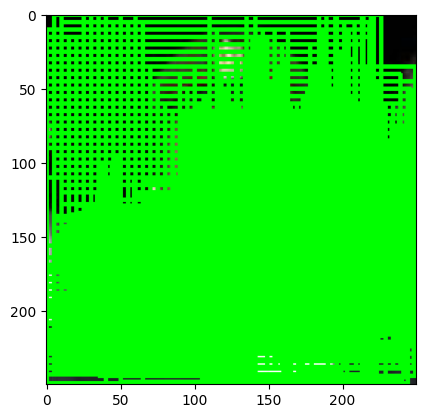

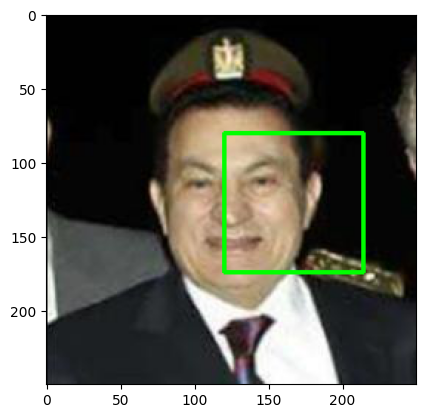

RGB
(250, 250)
{'Getting Subwindows': 0.17420101165771484, 'Resizing Subwindows': 0.3120877742767334, 'Normalize': 1.2159347534179688e-05, 'Extracting Features': 0.24799060821533203, 'Classifying': 0.08681273460388184}


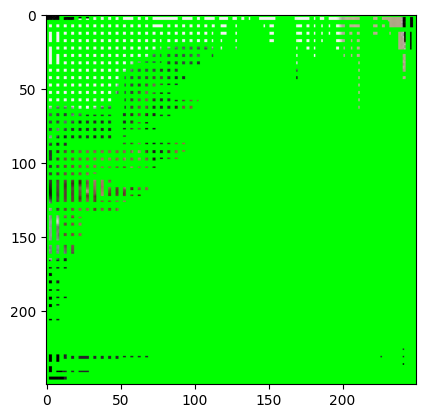

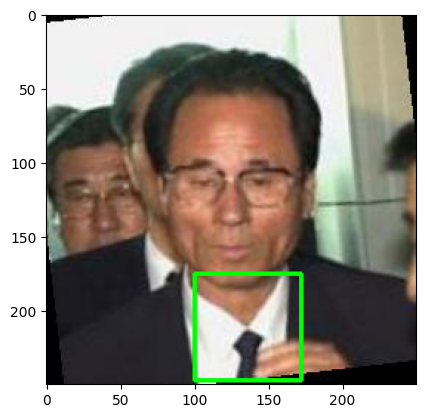

RGB
(250, 250)
{'Getting Subwindows': 0.10504698753356934, 'Resizing Subwindows': 0.31798768043518066, 'Normalize': 1.4781951904296875e-05, 'Extracting Features': 0.25012707710266113, 'Classifying': 0.08707427978515625}


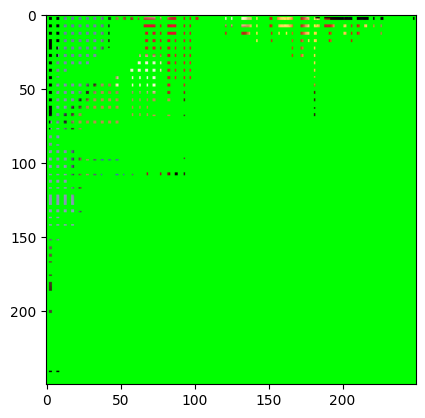

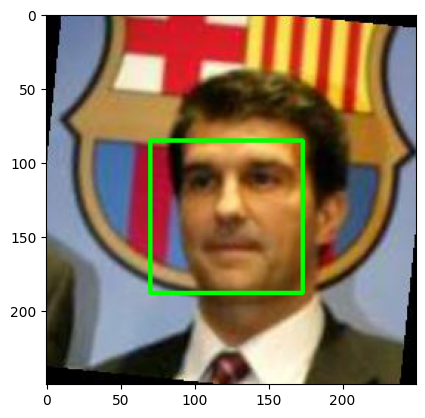

RGB
(250, 250)
{'Getting Subwindows': 0.18645191192626953, 'Resizing Subwindows': 0.29625415802001953, 'Normalize': 1.1205673217773438e-05, 'Extracting Features': 0.24166607856750488, 'Classifying': 0.08428406715393066}


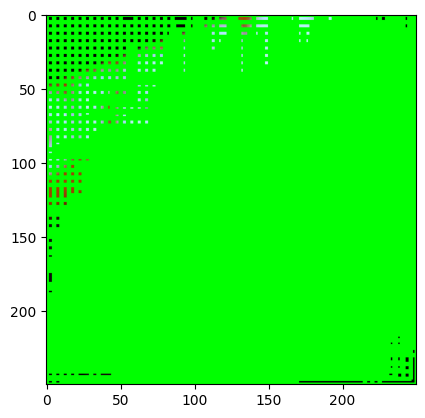

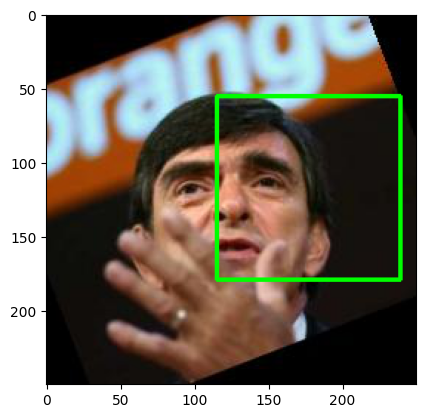

RGB
(250, 250)
{'Getting Subwindows': 0.1626887321472168, 'Resizing Subwindows': 0.3101661205291748, 'Normalize': 1.1444091796875e-05, 'Extracting Features': 0.24028635025024414, 'Classifying': 0.08162951469421387}


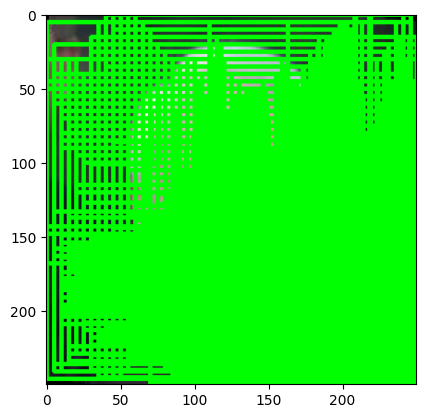

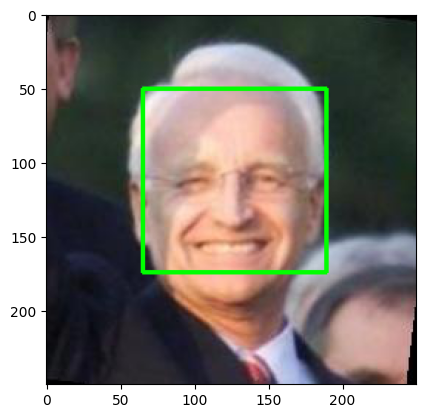

RGB
(250, 250)
{'Getting Subwindows': 0.10476851463317871, 'Resizing Subwindows': 0.3091113567352295, 'Normalize': 1.3828277587890625e-05, 'Extracting Features': 0.2527482509613037, 'Classifying': 0.08803415298461914}


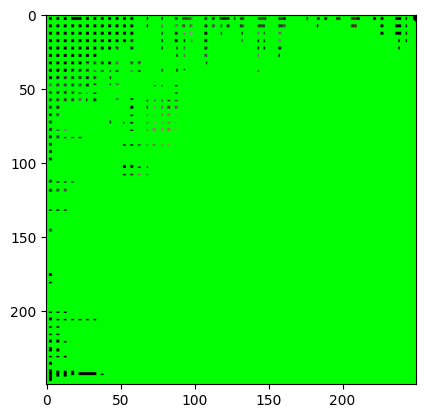

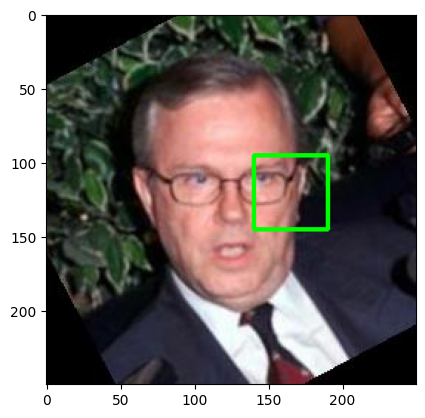

RGB
(250, 250)
{'Getting Subwindows': 0.0927419662475586, 'Resizing Subwindows': 0.44667506217956543, 'Normalize': 1.5497207641601562e-05, 'Extracting Features': 0.31142330169677734, 'Classifying': 0.12221288681030273}


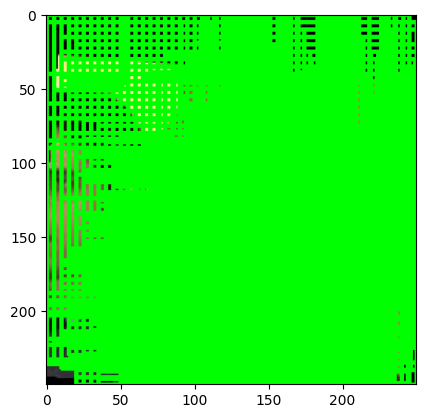

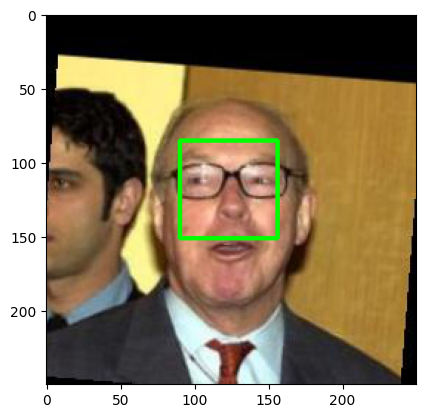

RGB
(250, 250)
{'Getting Subwindows': 0.12363648414611816, 'Resizing Subwindows': 0.4264552593231201, 'Normalize': 1.52587890625e-05, 'Extracting Features': 0.2967870235443115, 'Classifying': 0.12347745895385742}


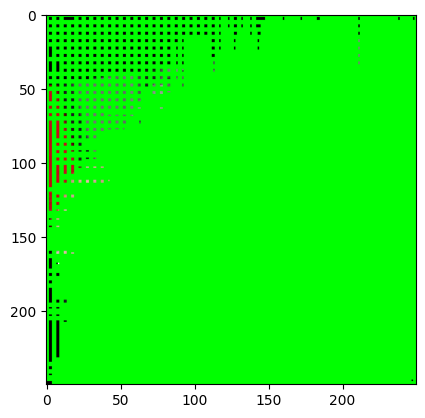

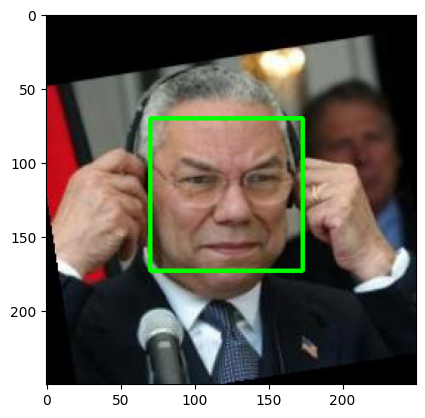

RGB
(250, 250)
{'Getting Subwindows': 0.15383124351501465, 'Resizing Subwindows': 0.3223884105682373, 'Normalize': 1.2636184692382812e-05, 'Extracting Features': 0.2463243007659912, 'Classifying': 0.0865478515625}


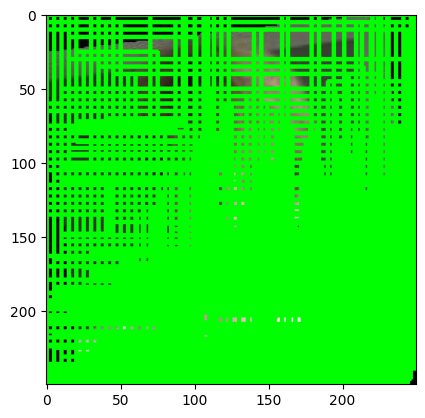

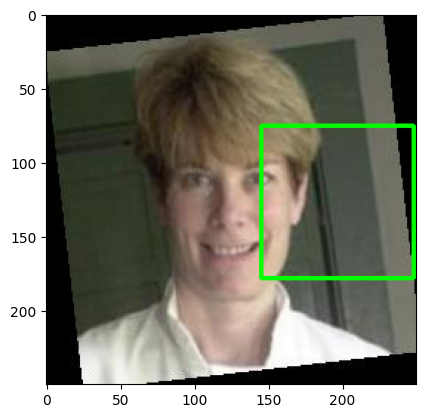

RGB
(250, 250)
{'Getting Subwindows': 0.0816650390625, 'Resizing Subwindows': 0.30232930183410645, 'Normalize': 1.049041748046875e-05, 'Extracting Features': 0.23223161697387695, 'Classifying': 0.08170390129089355}


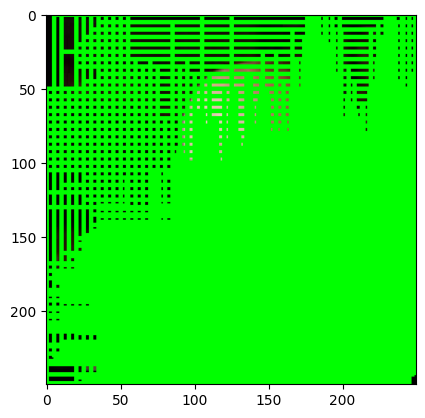

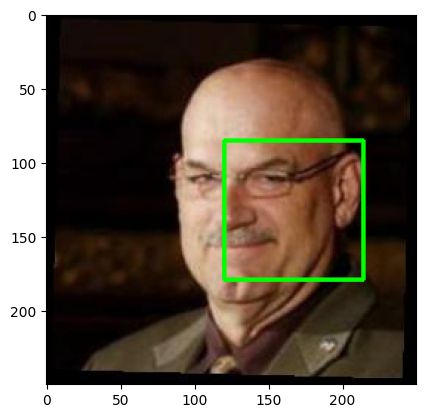

RGB
(250, 250)
{'Getting Subwindows': 0.08403205871582031, 'Resizing Subwindows': 0.3069784641265869, 'Normalize': 1.0967254638671875e-05, 'Extracting Features': 0.2668135166168213, 'Classifying': 0.08175849914550781}


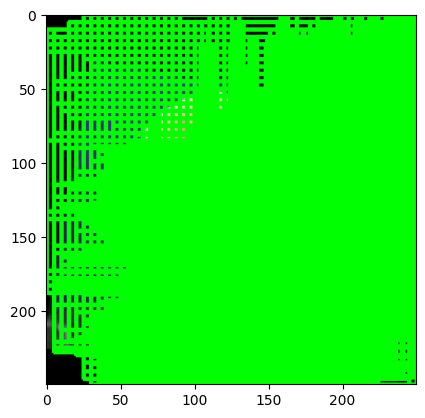

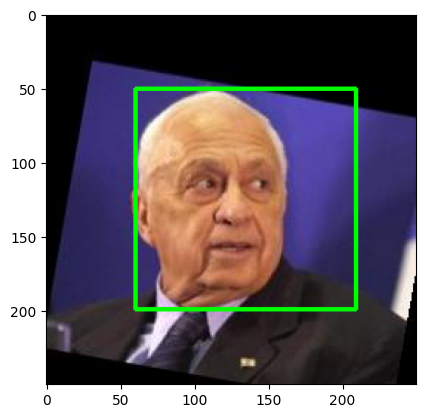

RGB
(250, 250)
{'Getting Subwindows': 0.08215999603271484, 'Resizing Subwindows': 0.3045506477355957, 'Normalize': 1.0967254638671875e-05, 'Extracting Features': 0.24010324478149414, 'Classifying': 0.08101344108581543}


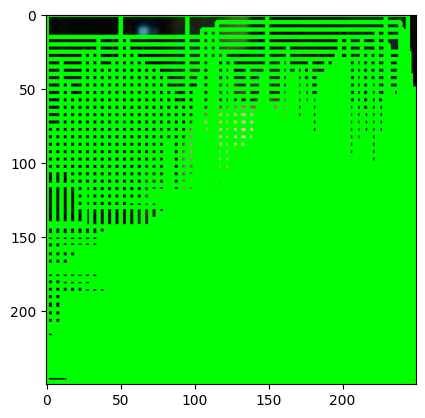

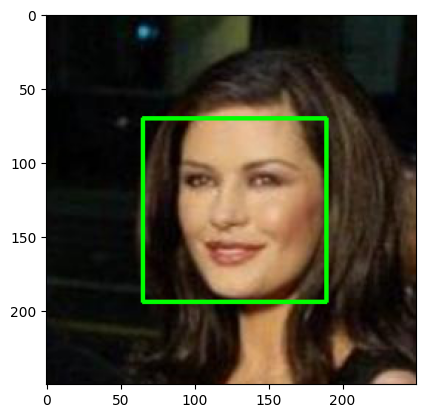

RGB
(250, 250)
{'Getting Subwindows': 0.11217594146728516, 'Resizing Subwindows': 0.30993151664733887, 'Normalize': 1.0967254638671875e-05, 'Extracting Features': 0.23829436302185059, 'Classifying': 0.0903620719909668}


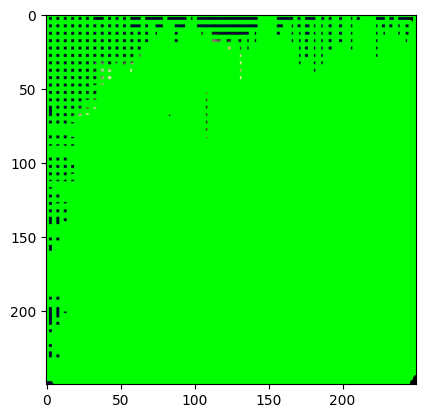

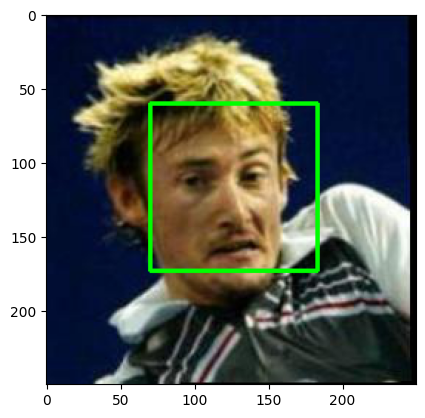

RGB
(250, 250)
{'Getting Subwindows': 0.08627700805664062, 'Resizing Subwindows': 0.3048381805419922, 'Normalize': 1.3589859008789062e-05, 'Extracting Features': 0.2371046543121338, 'Classifying': 0.08460640907287598}


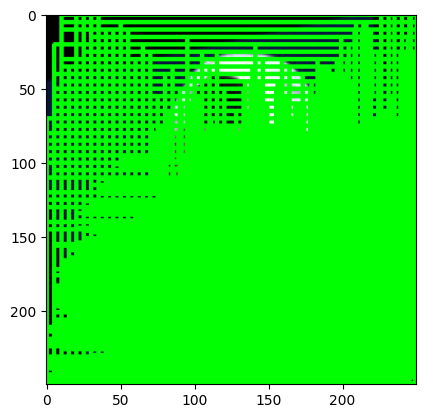

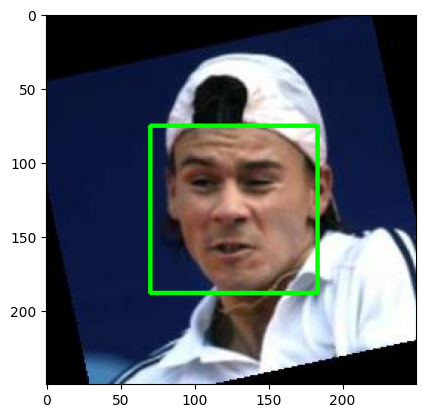

RGB
(250, 250)
{'Getting Subwindows': 0.08563399314880371, 'Resizing Subwindows': 0.32114553451538086, 'Normalize': 1.1205673217773438e-05, 'Extracting Features': 0.24644780158996582, 'Classifying': 0.09179210662841797}


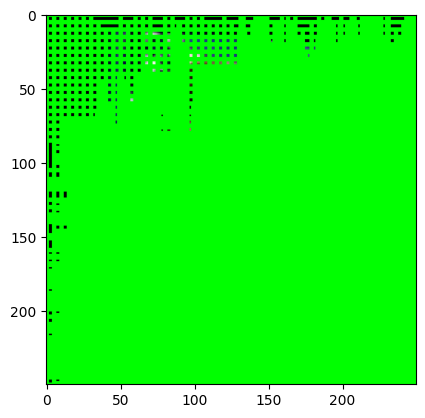

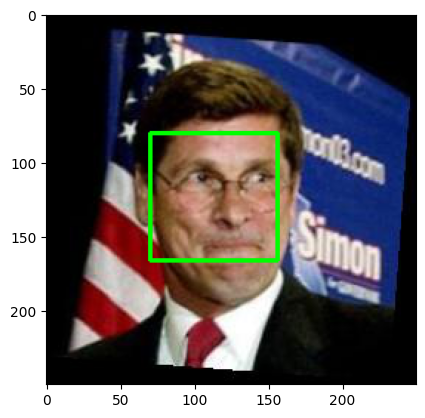

RGB
(250, 250)
{'Getting Subwindows': 0.08773040771484375, 'Resizing Subwindows': 0.3065145015716553, 'Normalize': 1.2874603271484375e-05, 'Extracting Features': 0.26045727729797363, 'Classifying': 0.08935809135437012}


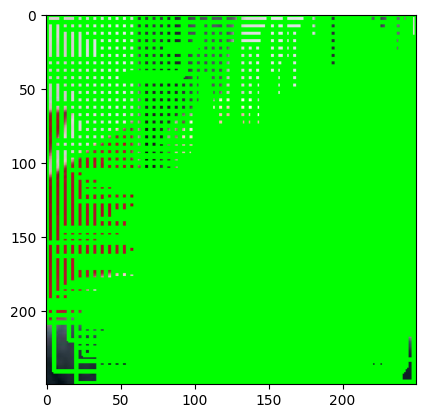

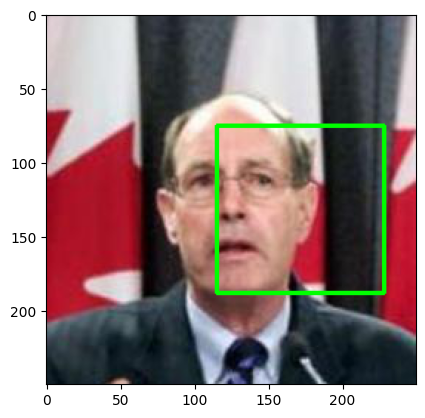

RGB
(250, 250)
{'Getting Subwindows': 0.08552360534667969, 'Resizing Subwindows': 0.33931922912597656, 'Normalize': 1.4066696166992188e-05, 'Extracting Features': 0.26277971267700195, 'Classifying': 0.10096096992492676}


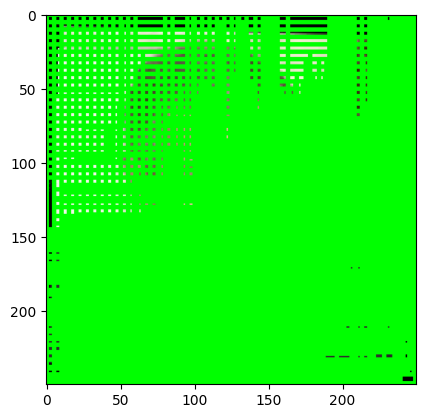

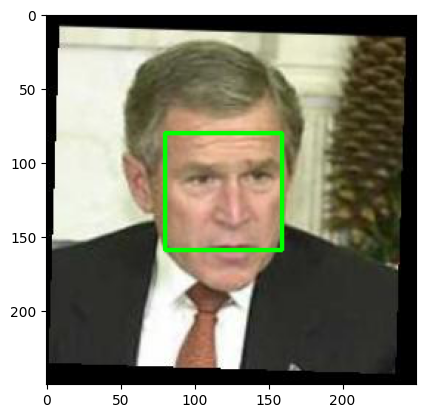

RGB
(250, 250)
{'Getting Subwindows': 0.09947323799133301, 'Resizing Subwindows': 0.47167158126831055, 'Normalize': 1.6927719116210938e-05, 'Extracting Features': 0.32395148277282715, 'Classifying': 0.1361989974975586}


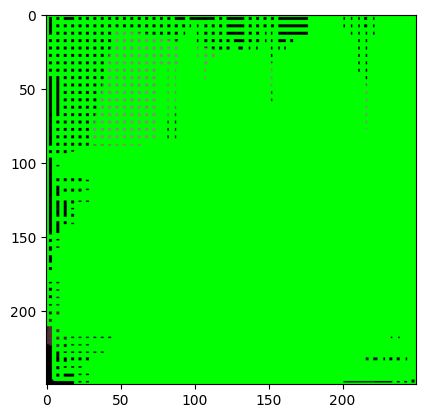

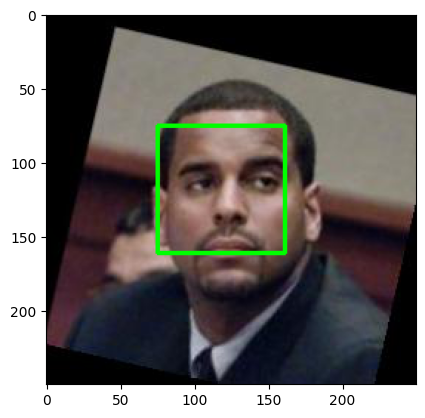

RGB
(250, 250)
{'Getting Subwindows': 0.0915067195892334, 'Resizing Subwindows': 0.44671010971069336, 'Normalize': 1.6450881958007812e-05, 'Extracting Features': 0.3230857849121094, 'Classifying': 0.1285233497619629}


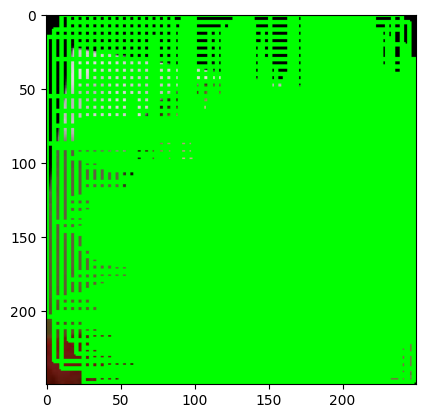

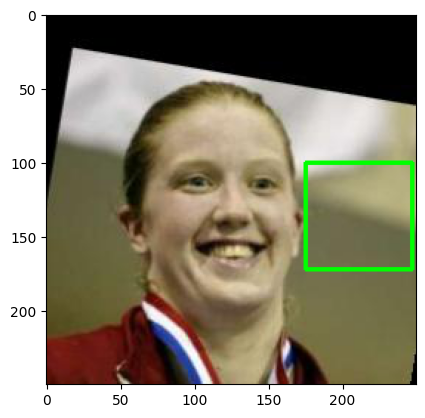

RGB
(250, 250)
{'Getting Subwindows': 0.10439443588256836, 'Resizing Subwindows': 0.37989282608032227, 'Normalize': 1.52587890625e-05, 'Extracting Features': 0.27694225311279297, 'Classifying': 0.10407567024230957}


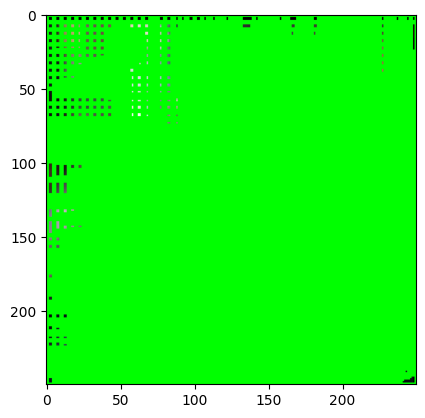

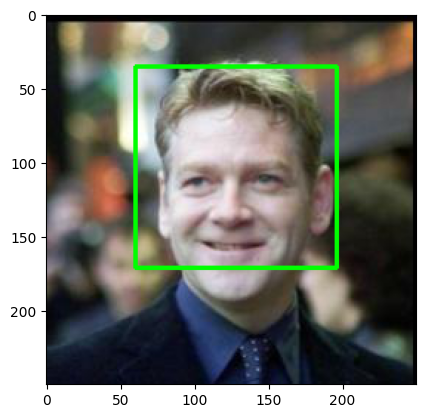

In [ ]:
for i in show_images:
  # >>>> Read image <<<<
  img = Image.open(all_images_names[i])
  print(img.mode)
  img = np.array(img)
  org_sh = img.shape
  if not rectangles_only:
    plt.imshow(img)
    plt.show()
  # get subwindows
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img2.shape)

  # >>>> Normalize image <<<<
  # normalize image
  # img2 = (img2 - img2.mean()) / img2.std()
  # img2 = cv2.resize(img, resize_to)
  # print(img2.shape)

  # img2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # resize image
  # img2 = cv2.resize(img2, (570, 380))

  # show image
  if not rectangles_only:
    plt.imshow(img2, cmap='gray')
    plt.show()

  # +++++++++++++++++++++
  # find face
  # >>>> Find face <<<<
  face_coordinates, region_max_conf, max_conf , timing=\
                  find_face(img2, \
                              cascadeClassifier, \
                              feature_extractor, \
                              window_size=(19, 19), \
                              scale_dist=1.1, \
                              max_size=300, \
                              stride=5, \
                              device=device, \
                              verbose=False,
                              report_time=True)
  print(timing)
  # region_max_conf *= img.shape[0] / resize_to[0]
  # ++++++++++++++++++++
  # rectangles 
  # >>>> Draw rectangles <<<<
  tmp_img = img.copy()
  for face_coordinate in face_coordinates:
      for x1, y1, x2, y2 in face_coordinate:
          cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  # if not rectangles_only:          
  plt.imshow(tmp_img)
  plt.show()

  # >>>> Draw rectangles with max confidence <<<<
  # amx confidence
  tmp_img = img.copy()
  x1, y1, x2, y2 = region_max_conf
  cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  plt.imshow(tmp_img)
  plt.show()

